In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import glm
from statsmodels.formula.api import ols
import scipy.stats as stats
import openpyxl
import gpboost as gpb


# https://towardsdatascience.com/tree-boosted-mixed-effects-models-4df610b624cb

In [2]:
data = pd.read_excel('fx_beer_data.xlsx', engine='openpyxl',
                     sheet_name=['fx', 'tot', 'gfc', 'yield', 'cpi', 'prod'])

# %% global variables
start_date_panel = '1996-04-30'
end_date_panel = '2023-02-28'

## FX PRICE DATA
g12_tickers = ['eurusd', 'cadusd', 'jpyusd', 'gbpusd', 'sekusd', 'nokusd', 'chfusd', 'audusd', 'nzdusd',
               'plnusd', 'hufusd', 'czkusd']
g9_tickers = ['eurusd', 'cadusd', 'jpyusd', 'gbpusd', 'sekusd', 'nokusd', 'chfusd', 'audusd', 'nzdusd']
cee3_tickers = ['plnusd', 'hufusd', 'czkusd']

fx_data = data['fx'].set_index('date')
fx_data = fx_data.resample('M').last()
fx_data['cadusd'] = 1 / fx_data.usdcad
fx_data['jpyusd'] = 1 / fx_data.usdjpy
fx_data['sekusd'] = 1 / fx_data.usdsek
fx_data['nokusd'] = 1 / fx_data.usdnok
fx_data['chfusd'] = 1 / fx_data.usdchf
fx_data['plnusd'] = 1 / fx_data.usdpln
fx_data['hufusd'] = 1 / fx_data.usdhuf
fx_data['czkusd'] = 1 / fx_data.usdczk

fx = fx_data[g12_tickers]
fx_log = np.log(fx)
fx_log = fx_log.loc[start_date_panel:]

# TOT DATA
tot_data = data['tot'].set_index('date')
tot_data = tot_data.resample('M').last()

tot_index = tot_data.copy()
tot_index = tot_index + 100
tot_ratio = tot_index.iloc[:, 1:].div(tot_index.usd_tot, axis=0)  # tot relative to USA
tot_log_ratio = np.log(tot_ratio).shift(1).dropna()  # take log and shift a month for point in time issues
tot_log_ratio = tot_log_ratio.loc[start_date_panel:]


# GFC DATA
gfc_data = data['gfc'].set_index('date')
gfc_data.index = pd.to_datetime(gfc_data.index, format='%Y')
gfc_data = gfc_data.resample('A').last()  # resample to end of year
gfc_data_monthly = gfc_data.resample('M').last().ffill() # resample eom & ffill missing
gfc_new_date_range = pd.date_range(start='1996-01-31', end=end_date_panel, freq='M')
gfc_reindexed = gfc_data_monthly.reindex(gfc_new_date_range, method='ffill')
gfc_ratio = gfc_reindexed.iloc[:, 1:].div(gfc_reindexed.usd_gfc, axis=0)  # gfc relative to USA
gfc_log_ratio = np.log(gfc_ratio)  # point in time not necessary, already year lag tsss
gfc_log_ratio = gfc_log_ratio.loc[start_date_panel:]


# YIELD DATA
g9_yield_data = data['yield'].iloc[:, :11].set_index('date')
g9_yield_data_monthly = g9_yield_data.resample('M').last()
g9_yield_diff = g9_yield_data_monthly.iloc[:, 1:].sub(g9_yield_data_monthly.usd_yield, axis=0)  # yield diff with  USA
g9_yield_diff = g9_yield_diff.loc[start_date_panel:]

cee3_yield_data = data['yield'].iloc[:, 11:15].set_index('date.1')
cee3_yield_data.index.name = 'date'
cee3_yield_data_monthly = cee3_yield_data.resample('M').last()
cee3_yield_diff = cee3_yield_data_monthly.sub(g9_yield_data_monthly['2001':].usd_yield, axis=0)  # yield diff with  USA
cee3_yield_diff = cee3_yield_diff.loc['2001-01-31':]


# CPI

cpi_data = data['cpi'].iloc[:, :12].set_index('date')
cpi_data = cpi_data.resample('M').last()
cpi_new_date_range = pd.date_range(start='1996-01-31', end=end_date_panel, freq='M')
cpi_reindexed = cpi_data.reindex(cpi_new_date_range)
cpi_reindexed = cpi_reindexed.ffill()
cpi_ratio = cpi_reindexed.iloc[:, 1:].div(cpi_reindexed.usd_cpi, axis=0)  # relative cpi
cpi_log_ratio = np.log(cpi_ratio)  # take log, wait to shift for point in time, add nzd & aud first

cpi_data_audnzd = data['cpi'].iloc[:, 12:].set_index('date.1')
cpi_data_audnzd = cpi_data_audnzd.loc[:'2022-12-30']
cpi_data_audnzd_monthly = cpi_data_audnzd.resample('M').last().ffill()
cpi_data_audnzd_monthly_reindexed = cpi_data_audnzd_monthly.reindex(cpi_new_date_range)
cpi_data_audnzd_monthly_reindexed = cpi_data_audnzd_monthly_reindexed.ffill()
cpi_data_audnzd_ratio = cpi_data_audnzd_monthly_reindexed.div(cpi_reindexed.usd_cpi, axis=0)
cpi_audnzd_log_ratio = np.log(cpi_data_audnzd_ratio)

cpi_log_ratio = cpi_log_ratio.join(cpi_audnzd_log_ratio)
cpi_log_ratio = cpi_log_ratio.shift(1).dropna()  # make point in time and lag a month
cpi_log_ratio = cpi_log_ratio[['eur_cpi', 'cad_cpi', 'jpy_cpi', 'gbp_cpi', 'sek_cpi',
                               'nok_cpi', 'chf_cpi', 'aud_cpi', 'nzd_cpi', 'pln_cpi',
                               'huf_cpi', 'czk_cpi']]  # reorder columns just for my sake of mind
cpi_log_ratio = cpi_log_ratio.loc[start_date_panel:]


# PROD DATA
prod_data = data['prod'].set_index('date')
prod_data = prod_data.resample('M').last().ffill()

prod_new_date_range = pd.date_range(start='1996-01-31', end=end_date_panel, freq='M')
prod_reindexed = prod_data.reindex(prod_new_date_range)
prod_reindexed = prod_reindexed.ffill()
prod_ratio = prod_reindexed.iloc[:, 1:].div(prod_reindexed.usd_prod, axis=0)  # relative to us
prod_log_ratio = np.log(prod_ratio).shift(3).dropna()  # quarter lag


In [15]:
import sklearn.datasets as datasets

# Simulate data
ntrain = 5000 # number of samples for training
n = 2 * ntrain # combined number of training and test data
m = 500  # number of categories / levels for grouping variable
sigma2_1 = 1  # random effect variance
sigma2 = 1 ** 2  # error variance
# Simulate non-linear mean function
np.random.seed(1)
X, F = datasets.make_friedman3(n_samples=n)
X = pd.DataFrame(X,columns=['variable_1','variable_2','variable_3','variable_4'])
F = F * 10**0.5 # with this choice, the fixed-effects regression function has the same variance as the random effects
# Simulate random effects
group_train = np.arange(ntrain)  # grouping variable
for i in range(m):
    group_train[int(i * ntrain / m):int((i + 1) * ntrain / m)] = i
group_test = np.arange(ntrain) # grouping variable for test data. Some existing and some new groups
m_test = 2 * m
for i in range(m_test):
    group_test[int(i * ntrain / m_test):int((i + 1) * ntrain / m_test)] = i
group = np.concatenate((group_train,group_test))
b = np.sqrt(sigma2_1) * np.random.normal(size=m_test)  # simulate random effects
Zb = b[group]
# Put everything together
xi = np.sqrt(sigma2) * np.random.normal(size=n)  # simulate error term
y = F + Zb + xi  # observed data
# split train and test data
y_train = y[0:ntrain]
y_test = y[ntrain:n]
X_train = X.iloc[0:ntrain,]
X_test = X.iloc[ntrain:n,]

In [31]:
g9_panels = []
for index, currency in enumerate(g9_tickers):
    panel = fx_log[[g9_tickers[index]]].copy()
    panel.rename(columns={currency: 'fx_log'}, inplace=True)
    panel['currency'] = currency
    panel = panel[['currency', 'fx_log']]
    panel['tot_log_ratio'] = tot_log_ratio.iloc[:, index]
    panel['gfc_log_ratio'] = gfc_log_ratio.iloc[:, index]
    panel['yield_diff'] = g9_yield_diff.iloc[:, index]
    panel['cpi_log_ratio'] = cpi_log_ratio.iloc[:, index]
    panel['prod_log_ratio'] = prod_log_ratio.iloc[:, index]
    g9_panels.append(panel)

cee3_panels = []
for index, currency in enumerate(cee3_tickers):
    panel = fx_log[[cee3_tickers[index]]].copy()
    panel.rename(columns={currency: 'fx_log'}, inplace=True)
    panel['currency'] = currency
    panel = panel[['currency', 'fx_log']]
    panel['tot_log_ratio'] = tot_log_ratio.iloc[:, index + 9]
    panel['gfc_log_ratio'] = gfc_log_ratio.iloc[:, index + 9]
    panel['yield_diff'] = cee3_yield_diff.iloc[:, index]
    panel['cpi_log_ratio'] = cpi_log_ratio.iloc[:, index + 9]
    panel['prod_log_ratio'] = prod_log_ratio.iloc[:, index + 9]
    panel = panel.loc['2001-01-31':]
    cee3_panels.append(panel)

data = pd.concat(g9_panels+cee3_panels, axis=0)

In [32]:
from sklearn import preprocessing 

le = preprocessing.LabelEncoder()
groups = le.fit_transform(data['currency'])
data = data.drop('currency', axis=1)
data.head()

,fx_log,tot_log_ratio,gfc_log_ratio,yield_diff,cpi_log_ratio,prod_log_ratio
date,,,,,,
1996-04-30,0.237756,0.001405,0.035807,-0.331,0.072854,0.188791
1996-05-31,0.243338,-0.001903,0.035807,-0.356,0.070308,0.188791
1996-06-30,0.247563,-0.004787,0.035807,-0.206,0.070988,0.152291
1996-07-31,0.274597,0.002308,0.035807,-0.421,0.070350,0.152291
1996-08-31,0.272238,0.003903,0.035807,-0.557,0.068437,0.152291


In [177]:
# modeling fixed effect, to model mixed effects see: https://towardsdatascience.com/tree-boosted-mixed-effects-models-4df610b624cb
y_train = data['fx_log']
X_train = data.drop('fx_log', axis=1)

gp_model = gpb.GPModel(group_data=groups)
data_train = gpb.Dataset(X_train, y_train)

params = { 'objective': 'l2', 'verbose': 0}

# Small grid and deterministic search
param_grid_small = {'learning_rate': [1,0.1,0.01, 0.001, 0.0001], 'min_data_in_leaf': [1, 2, 5, 20, 30, 50, 75, 100],
                    'max_depth': [2,3,4,5,6,7]}

from sklearn.model_selection import KFold
folds = list(KFold(n_splits=4, random_state=None, shuffle=False).split(X_train))

opt_params = gpb.grid_search_tune_parameters(param_grid=param_grid_small,
                                             params=params,
                                             num_try_random=None,
                                             folds=folds,
                                             gp_model=gp_model,
                                             use_gp_model_for_validation=True,
                                             train_set=data_train,
                                             verbose_eval=1,
                                             num_boost_round=30, 
                                             early_stopping_rounds=10,
                                             seed=1,
                                             metrics='mse')

print("Best number of iterations: " + str(opt_params['best_iter']))
print("Best score: " + str(opt_params['best_score']))
print("Best parameters: " + str(opt_params['best_params']))

Starting deterministic grid search with 240 parameter combinations...
Trying parameter combination 1 of 240: {'learning_rate': 1.0, 'min_data_in_leaf': 1, 'max_depth': 2} ...
***** New best test score (l2 = 3.7577051550835714) found for the following parameter combination:
{'learning_rate': 1.0, 'min_data_in_leaf': 1, 'max_depth': 2, 'num_boost_round': 6}
Trying parameter combination 2 of 240: {'learning_rate': 0.1, 'min_data_in_leaf': 1, 'max_depth': 2} ...
***** New best test score (l2 = 3.0268882767510017) found for the following parameter combination:
{'learning_rate': 0.1, 'min_data_in_leaf': 1, 'max_depth': 2, 'num_boost_round': 1}
Trying parameter combination 3 of 240: {'learning_rate': 0.01, 'min_data_in_leaf': 1, 'max_depth': 2} ...
***** New best test score (l2 = 3.021778496807669) found for the following parameter combination:
{'learning_rate': 0.01, 'min_data_in_leaf': 1, 'max_depth': 2, 'num_boost_round': 0}
Trying parameter combination 4 of 240: {'learning_rate': 0.001, '

In [182]:
y_train = data['fx_log']
X_train = data.drop('fx_log', axis=1)

gp_model = gpb.GPModel(group_data=groups)
# create dataset for gpb.train function
data_train = gpb.Dataset(X_train, y_train)
# specify tree-boosting parameters as a dict
params = { 'objective': 'regression', 'learning_rate': 0.1, 'min_data_in_leaf': 2, 'max_depth': 6}
# train model
bst = gpb.train(params=params, train_set=data_train, gp_model=gp_model, num_boost_round=20)
gp_model.summary() # estimated covariance parameters

# Make predictions
pred = bst.predict(data=X_train, group_data_pred=groups)

[GPBoost] [Info] Total Bins 1272
[GPBoost] [Info] Number of data points in the train set: 3705, number of used features: 5
[GPBoost] [Info] [GPBoost with gaussian likelihood]: initscore=-1.510988
[GPBoost] [Info] Start training from score -1.510988
Covariance parameters (random effects):
            Param.
Error_term  0.0500
Group_1     3.4618


<Axes: xlabel='date'>

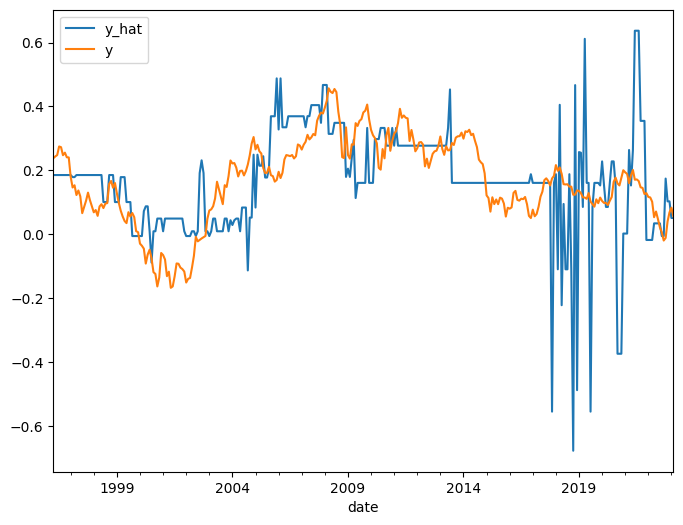

In [183]:
predictions = pd.DataFrame({'y_hat': pred['response_mean']}).copy()
predictions['y'] = y_train.values
predictions['currency'] = le.inverse_transform(groups)
predictions.index = data.index

predictions[predictions['currency']=='eurusd'][['y_hat', 'y']].plot(figsize=(8,6))

<Axes: xlabel='date'>

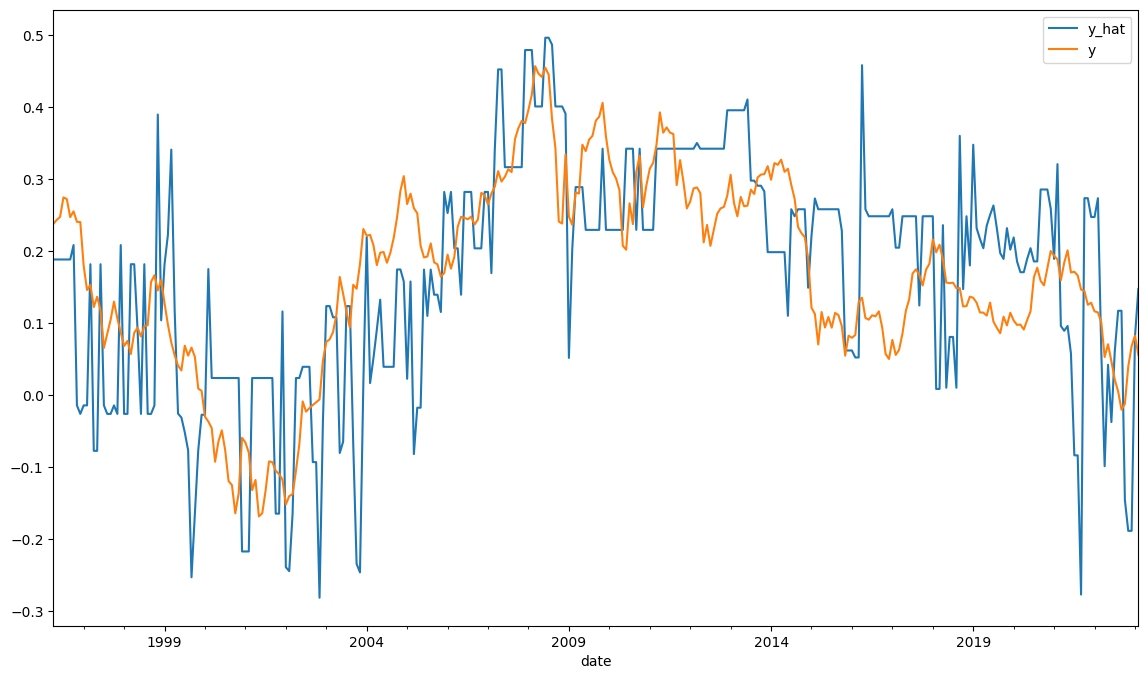

In [35]:
le.inverse_transform(groups)

array(['eurusd', 'eurusd', 'eurusd', ..., 'czkusd', 'czkusd', 'czkusd'],
      dtype=object)